# Debugging the Pipline

in this notebook we want to get our pipeline up and running and test the key components




In [1]:
import json
import random as rd
import matplotlib.image as mpimg
import cv2
import wandb
import torch

from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

from src.globals import *
from src.visualization.show_image import show_image
from src.register_datasets import register_datasets
from src.test import do_test
from src.train import do_train



## Convert ACDC data to COCO format

check coco json file:

In [2]:
with open("./data/dataInCOCO/train/cell_acdc_coco_ds.json") as file:
    train_dict = json.load(file)

In [3]:
print(list(train_dict.keys()),"\n")
print(json.dumps(train_dict["info"], indent=4))
if False:
    print("\ncategories:\n",json.dumps(train_dict["categories"], indent=4))
    print("\nimages:\n",json.dumps(train_dict["images"][0], indent=4))
    print("\nannotations:\n",json.dumps(train_dict["annotations"][0], indent=4))


['info', 'licenses', 'categories', 'images', 'annotations'] 

{
    "description": "Cell ACDC data in COCO format",
    "url": "",
    "version": "0.1.0",
    "year": 2022,
    "contributor": "Florian Bridges",
    "date_created": "2022-10-16 09:22:07.477724"
}


/Show some raw images:

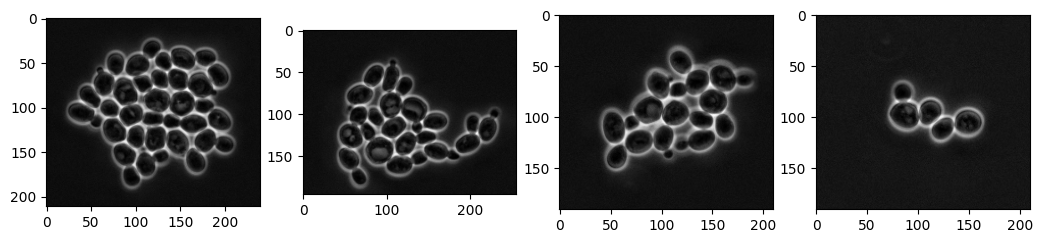

In [4]:
rd.seed(1337)
images_meta_data = rd.sample(train_dict["images"], 4)
imgs = [mpimg.imread("./data/dataInCOCO/train/images/" + image["file_name"]) for image in images_meta_data]
show_image(imgs)


## Detectron2

### Register Datasets

In [5]:
register_datasets()

### Inspect Groundtruth


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



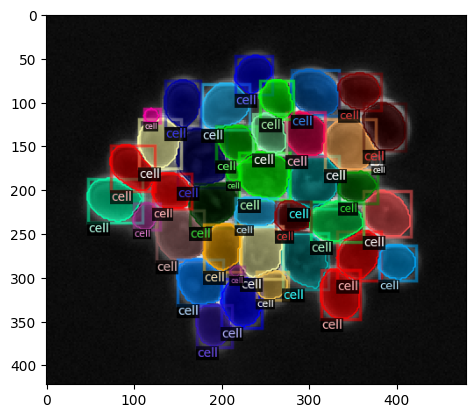

5061


In [6]:
cfg = get_cfg()
cfg.DATASETS.TRAIN = (SINGLE_POINT_DATASET,)

in_image_id = images_meta_data[0]["id"]
in_image_json = list(filter(lambda image: image["image_id"] == in_image_id, DatasetCatalog.get(SINGLE_POINT_DATASET) ))[0]
in_image = cv2.imread(in_image_json["file_name"]) #imgs[0]
visualizer = Visualizer(in_image[:, :, ::-1], metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=2)
out = visualizer.draw_dataset_dict(in_image_json)
out_image = out.get_image()[:, :, ::-1]
show_image(out_image)
print(in_image_id)


## Train a Model

### Train Model with single Datapoint

define cfg and save as yaml file

In [7]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (SINGLE_POINT_DATASET,)
cfg.DATASETS.TEST = (SINGLE_POINT_DATASET,)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.OUTPUT_DIR = "./output"

#with open("./src/pipeline_configs/single_datapoint.yaml","w") as file:
#    file.write(cfg.dump())

Train model from terminal

In [8]:
#!python src/pipeline_runner.py -f ./src/pipeline_configs/single_datapoint.yaml

WARNING [10/13 14:13:45 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



/home/ubuntu/.local/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


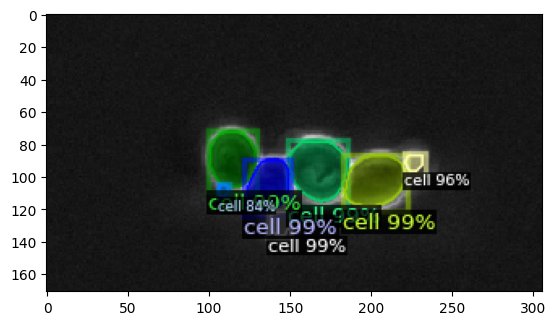

In [9]:
import os
from detectron2.engine import DefaultPredictor

logger = setup_logger(output="./log/main.log")
logger.setLevel(0)
cfg = get_cfg()
cfg.merge_from_file("./src/pipeline_configs/single_datapoint.yaml")
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

#from IPython.display import Image
im = cv2.imread(DatasetCatalog.get(SINGLE_POINT_DATASET)[0]["file_name"])

outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
show_image(out.get_image()[:, :, ::-1])

In [26]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (TRAIN_DATASET_FULL,)
cfg.DATASETS.TEST = (TEST_DATASET_FULL,)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.OUTPUT_DIR = "./output"

with open("./src/pipeline_configs/default_config.yaml","w") as file:
    file.write(cfg.dump())


In [28]:
!python src/pipeline_runner.py -f ./src/pipeline_configs/default_config.yaml

[10/13 14:21:19 detectron2]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequ

WARNING [10/13 14:13:49 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



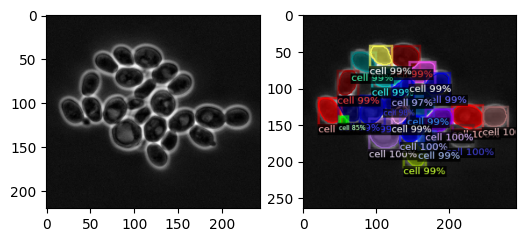

In [12]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

#from IPython.display import Image
im = cv2.imread(DatasetCatalog.get(TEST_DATASET_FULL)[100]["file_name"])

outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
show_image([im,out.get_image()[:, :, ::-1]])

In [13]:
evaluator = COCOEvaluator(TEST_DATASET_FULL, output_dir=cfg.OUTPUT_DIR)
data_loader = build_detection_test_loader(cfg, TEST_DATASET_FULL)
evaluator = COCOEvaluator(TEST_DATASET_FULL, output_dir=cfg.OUTPUT_DIR)
results_i = inference_on_dataset(predictor.model, data_loader, evaluator)
print(results_i)

WARNING [10/13 14:13:50 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.776
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.931
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.900
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.064
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.529
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.805
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | m

In [14]:
evaluator.evaluate([DatasetCatalog.get(TEST_DATASET_FULL)[12]["image_id"]])

WARNING [10/13 14:15:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.793
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.793
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.225
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.800
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.800
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | m

OrderedDict([('bbox',
              {'AP': 79.27392739273927,
               'AP50': 100.0,
               'AP75': 100.0,
               'APs': 79.27392739273927,
               'APm': nan,
               'APl': nan}),
             ('segm',
              {'AP': 90.0990099009901,
               'AP50': 100.0,
               'AP75': 100.0,
               'APs': 90.0990099009901,
               'APm': nan,
               'APl': nan})])

In [29]:
result_array = []
for image_id in [image["image_id"] for image in DatasetCatalog.get(TEST_DATASET_FULL)]:
    result = evaluator.evaluate(image_id)
    result_array.append(result)
print(result_array)
aps = [result['segm']['AP'] for result in result_array]
worse_aps_ids = [aps.index(ap) for ap in aps if ap < 70]
print(worse_aps_ids)

WARNING [10/13 14:54:12 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.728
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.832
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.832
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.733
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.167
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.733
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.733
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | m

## Some of the worse performing Images

In [42]:
worse_aps_ids = [aps.index(ap) for ap in aps if ap < 66]
print(worse_aps_ids)

[233]


WARNING [10/13 15:03:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



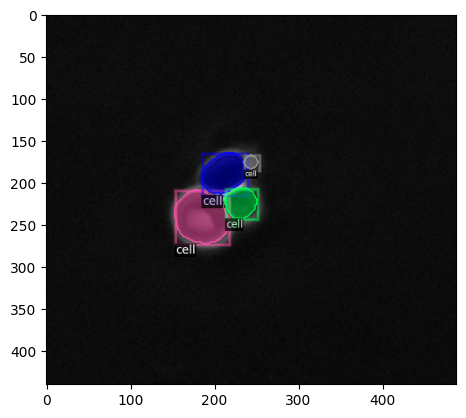

In [43]:
def plot_ground_truth(image_json):

    in_image = cv2.imread(image_json["file_name"])
    visualizer = Visualizer(in_image[:, :, ::-1], metadata=MetadataCatalog.get(TEST_DATASET_FULL), scale=2)
    out = visualizer.draw_dataset_dict(image_json)
    out_image = out.get_image()[:, :, ::-1]
    #show_image([in_image,out_image])
    show_image(out_image)

image_json = DatasetCatalog.get(TEST_DATASET_FULL)[worse_aps_ids[0]]
plot_ground_truth(image_json)

WARNING [10/13 15:03:36 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



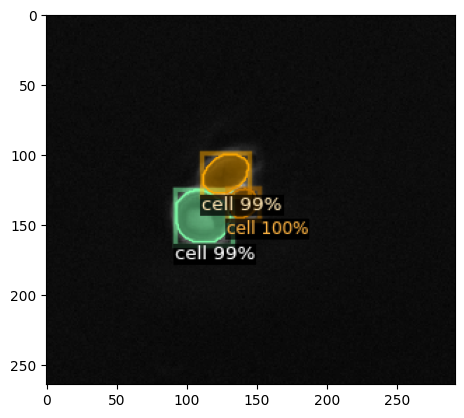

In [44]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

#from IPython.display import Image
im = cv2.imread(DatasetCatalog.get(TEST_DATASET_FULL)[233]["file_name"])

outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
show_image(out.get_image()[:, :, ::-1])

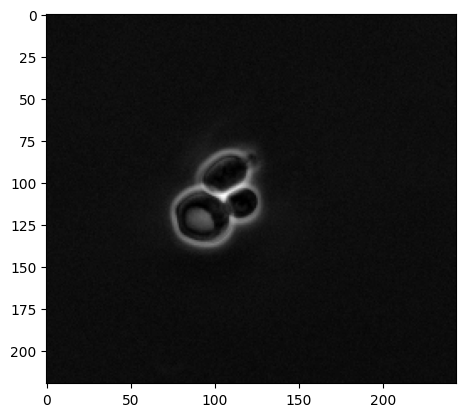

In [45]:
show_image(im)